# (Yet Another) Titanic Data Set Classification with Random Forest
- [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['train.csv', 'test.csv']


In [89]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [97]:
# Prepare data set
X = df_train.drop(columns='Survived')
X_test = df_test.copy()
PassengerId_test = X_test['PassengerId']
y = df_train['Survived']

# Fill missing values with mean values for Age column
X['Age'].fillna(X['Age'].mean(), inplace=True)
X_test['Age'].fillna(X['Age'].mean(), inplace=True)
X_test['Fare'].fillna(X['Fare'].mean(), inplace=True)

# Drop columns
X.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)
X_test.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)

# Get list of numeric columns
numeric_columns = [col for col in X.columns if X.dtypes[col] != "object"]

## Explore the Numerical Columns with a Scatter Matrix

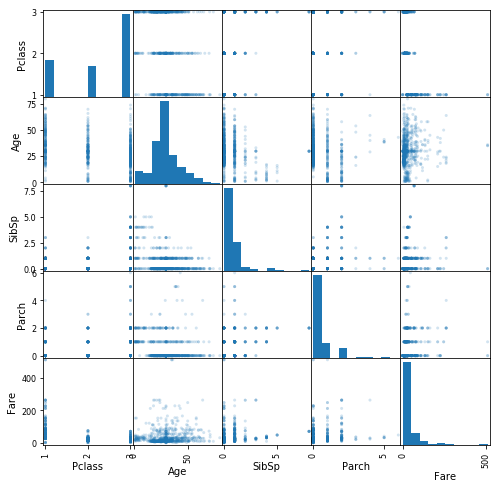

In [69]:
from pandas.plotting import scatter_matrix
scatter_matrix(X[numeric_columns], alpha=0.2, figsize=(8, 8));

## First Classification with the Numeric Columns

In [70]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)
model.fit(X[numeric_columns], y)

# Out-of-bag prediction score
model.oob_score_

0.6902356902356902

## Feature Importance of each Column
Take a look at the feature importance for each column. The importance is sometimes refered to as _gini importance_ or _mean decrease impurity_ and is defined as the total decrease in node impurity averaged over all trees of the ensemble

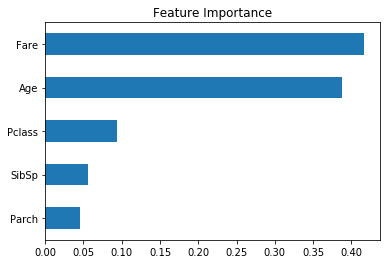

In [71]:
features = pd.Series(model.feature_importances_, index=X[numeric_columns].columns).sort_values()
features.plot(kind='barh', color='C0', title='Feature Importance');

## Transform Categorical Columns to One Hot Encoded Columns

In [98]:
# Get only first letter for each Cabin 
X['Cabin'] = X['Cabin'].apply(lambda x: 'NONE' if (isinstance(x, float) and np.isnan(x)) else x[0])
X_test['Cabin'] = X_test['Cabin'].apply(lambda x: 'NONE' if isinstance(x, float) and np.isnan(x) else x[0])

In [99]:
# Convert categorical columns to one-hot-encoded columns
for col in ['Cabin', 'Embarked', 'Sex']:
    X[col].fillna('NONE', inplace=True)
    one_hot_cols = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, one_hot_cols], axis=1).drop(columns=col)
    
    X_test[col].fillna('NONE', inplace=True)
    one_hot_cols = pd.get_dummies(X_test[col], prefix=col)
    X_test = pd.concat([X_test, one_hot_cols], axis=1).drop(columns=col)

# Add missing columns for test data
for col in list(set(X.columns) - set(X_test.columns)):
    n_rows = X_test.shape[0]
    X_test[col] = np.zeros((n_rows))

X.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NONE,Cabin_T,Embarked_C,Embarked_NONE,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,3,22.0,1,0,7.2500,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,3,26.0,0,0,7.9250,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
3,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
4,3,35.0,0,0,8.0500,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [79]:
model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)
model.fit(X, y)

# Out-of-bag prediction score
model.oob_score_

0.79685746352413023

## Feature Importance of each Column

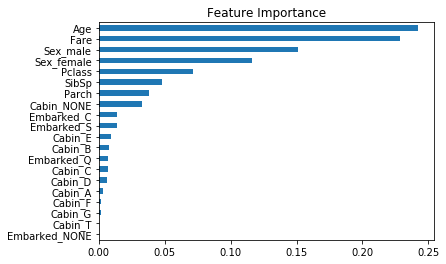

In [80]:
features = pd.Series(model.feature_importances_, index=X.columns).sort_values()
features.plot(kind='barh', color='C0', title='Feature Importance');

## Parameter Tuning Using Grid Search
Search for best parameter for number of trees (`n_estimators`) in the random forest and compare their accuracy.
- [sklearn.model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Model with rank: 1
Mean validation score: 0.813 (std: 0.045)
Parameters: {'n_estimators': 50}

Model with rank: 1
Mean validation score: 0.813 (std: 0.042)
Parameters: {'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.811 (std: 0.042)
Parameters: {'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.811 (std: 0.047)
Parameters: {'n_estimators': 2000}

Model with rank: 5
Mean validation score: 0.809 (std: 0.043)
Parameters: {'n_estimators': 100}

Model with rank: 5
Mean validation score: 0.809 (std: 0.044)
Parameters: {'n_estimators': 200}



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


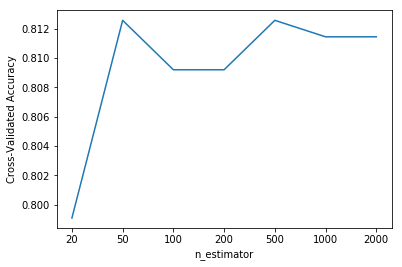

In [81]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

n_estimators = [20, 50, 100, 200, 500, 1000, 2000]
param_grid = dict(n_estimators=n_estimators)

grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

# Get results
results = grid.cv_results_

# Code adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
for i in range(1, 6):
    candidates = np.flatnonzero(results['rank_test_score'] == i)
    for candidate in candidates:
        print("Model with rank: {}".format(i))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
        print("Parameters: {}".format(results['params'][candidate]))
        print()

x_pos = range(len(n_estimators))
plt.plot(grid.cv_results_['mean_test_score'])
plt.xticks(x_pos, n_estimators)
plt.xlabel('n_estimator')
plt.ylabel('Cross-Validated Accuracy');

## Parameter Tuning using Randomized Search
Randomized search on hyperparameters for the number of trees (`n_estimators`) in the forest, number of features to consider when looking for the best split (`max_features`) and minimum number of samples required to be at a leaf node (`max_samples_leaf`). 

- [sklearn.model_selection.RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [82]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()

n_estimators = [20, 50, 100, 200, 500, 1000, 2000]
min_samples_leaf = [1, 2, 3, 4, 5, 6, 8, 9, 10]
max_features = ['auto', None, 'sqrt', 'log2', 0.2, 0.8]

param_grid = dict(n_estimators=n_estimators, 
                  min_samples_leaf=min_samples_leaf, 
                  max_features=max_features)

random_search = RandomizedSearchCV(clf, param_grid, n_iter=20)
random_search.fit(X, y)

# Get results
results = random_search.cv_results_

# Code adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
for i in range(1, 6):
    candidates = np.flatnonzero(results['rank_test_score'] == i)
    for candidate in candidates:
        print("Model with rank: {}".format(i))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
        print("Parameters: {}".format(results['params'][candidate]))
        print()

Model with rank: 1
Mean validation score: 0.826 (std: 0.023)
Parameters: {'n_estimators': 2000, 'min_samples_leaf': 5, 'max_features': 0.8}

Model with rank: 2
Mean validation score: 0.823 (std: 0.014)
Parameters: {'n_estimators': 1000, 'min_samples_leaf': 2, 'max_features': None}

Model with rank: 3
Mean validation score: 0.818 (std: 0.014)
Parameters: {'n_estimators': 500, 'min_samples_leaf': 4, 'max_features': 'auto'}

Model with rank: 4
Mean validation score: 0.816 (std: 0.015)
Parameters: {'n_estimators': 100, 'min_samples_leaf': 3, 'max_features': 0.2}

Model with rank: 5
Mean validation score: 0.815 (std: 0.015)
Parameters: {'n_estimators': 2000, 'min_samples_leaf': 4, 'max_features': 0.2}

Model with rank: 5
Mean validation score: 0.815 (std: 0.008)
Parameters: {'n_estimators': 100, 'min_samples_leaf': 4, 'max_features': 'auto'}



## Predict Test Data Set

In [120]:
y_pred = random_search.predict(X_test)

df_submission = pd.DataFrame({'PassengerId': PassengerId_test, 'Survived': y_pred}).set_index('PassengerId')
df_submission.to_csv('submission.csv')